In [1]:
# notebook to check out thermo 85 discrepancies

In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import cantera as ct
import rmgpy.species
import rmgpy.chemkin
import rmgpy.data.thermo


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the base model
# Load the base model and the covariance matrix
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/models/rmg_model'

base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
cti_file = os.path.join(basedir, 'chem_annotated.cti')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)
base_gas = ct.Solution(cti_file)

spec_dict = rmgpy.chemkin.load_species_dictionary(dictionary)


In [3]:
# Load the thermo 85 model
dir85 = '/work/westgroup/harris.se/autoscience/autoscience/debug/thermo85'

chemkin85 = os.path.join(dir85, 'thermo_only_85.inp')
cti_file85 = os.path.join(dir85, 'thermo_only_85.cti')
species_list85, reaction_list85 = rmgpy.chemkin.load_chemkin_file(chemkin85, dictionary_path=dictionary, transport_path=transport)
gas85 = ct.Solution(cti_file85)



In [4]:
print(base_gas.species()[85].thermo.coeffs)
print(gas85.species()[85].thermo.coeffs)

[ 9.49210000e+02  1.16605865e+01  4.41236559e-02 -2.07772408e-05
  4.03962387e-09 -2.86276164e-13 -4.21917163e+04 -2.50449631e+01
  2.98377104e-02  9.31369094e-02 -9.82324541e-05  5.84404205e-08
 -1.46144596e-11 -3.99837532e+04  3.04602026e+01]
[ 3.89750e+02  5.06938e+00  6.17267e-02 -3.87602e-05  1.15544e-08
 -1.31962e-12 -3.74807e+04  2.49020e+01  2.64807e+00  1.43215e-01
 -5.70354e-04  1.29368e-06 -1.06287e-09 -3.77222e+04  2.87831e+01]


In [5]:
base_gas.reactions()[1004]

<ElementaryReaction: C2H(4) + C2H5O(49) <=> C2H2(25) + CH3CHO(35)>

In [6]:
gas85.reactions()[1004]

<ElementaryReaction: C2H(4) + C2H5O(49) <=> C2H2(25) + CH3CHO(35)>

In [7]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)

In [8]:
# run the simulations
condition_index = 0
gas = base_gas

T = T7[condition_index]
P = P7[condition_index]
X = concentrations[condition_index]
t_end = 1.0  # time in seconds
gas.TPX = T, P, X

env = ct.Reservoir(ct.Solution('air.yaml'))
# env = ct.Reservoir(ct.Solution('air.xml'))
reactor = ct.IdealGasReactor(gas)
wall = ct.Wall(reactor, env, A=1.0, velocity=0)
reactor_net = ct.ReactorNet([reactor])

times = [0]
T = [reactor.T]
P = [reactor.thermo.P]
X = [reactor.thermo.X]  # mol fractions
# while reactor_net.time < t_end:
while reactor_net.time < t_end and reactor_net.time < 0.000000049083278185195194:
    reactor_net.step()

    times.append(reactor_net.time)
    T.append(reactor.T)
    P.append(reactor.thermo.P)
    X.append(reactor.thermo.X)
    
slopes = np.gradient(P, times)
i = np.argmax(slopes)
base_delay = times[i]
print(base_delay)

1.217513541493204e-07


In [9]:
reactor.thermo.X[85]

1.8813602625906059e-22

In [10]:
# run the changed thermo 85 simulation
# condition_index = 6

T = T7[condition_index]
P = P7[condition_index]
X = concentrations[condition_index]
# t_end = 1.0  # time in seconds
gas85 = ct.Solution(cti_file85)
gas85.TPX = T, P, X

env85 = ct.Reservoir(ct.Solution('air.yaml'))
# env = ct.Reservoir(ct.Solution('air.xml'))
reactor85 = ct.IdealGasReactor(gas85)
wall85 = ct.Wall(reactor85, env85, A=1.0, velocity=0)
reactor_net85 = ct.ReactorNet([reactor85])

times = [0]
T = [reactor85.T]
P = [reactor85.thermo.P]
X = [reactor85.thermo.X]  # mol fractions
# while reactor_net85.time < t_end or reactor_net85.time < 0.049083278185195194:
while reactor_net85.time < t_end and reactor_net85.time < 0.000000049083278185195194:
    reactor_net85.step()

    times.append(reactor_net85.time)
    T.append(reactor85.T)
    P.append(reactor85.thermo.P)
    X.append(reactor85.thermo.X)

# slopes = np.gradient(P, times)
# i = np.argmax(slopes)
# delay85 = times[i]
# print(delay85)

In [11]:
X[4][85]

IndexError: list index out of range

In [ ]:
reactor85.thermo.X[85]

In [ ]:
sp85 = base_gas.species()[85].name

# list the reactions that include that species
relevant_reactions = []
print('Base RMG Model')
for i, rxn in enumerate(base_gas.reactions()):
    if sp85 in rxn.reactants.keys():
        relevant_reactions.append(i)
        print(i, rxn, base_gas.net_rates_of_progress[i])
    elif sp85 in rxn.products.keys():
        relevant_reactions.append(i)
        print(i, rxn, base_gas.net_rates_of_progress[i])


In [20]:
# list the reactions that include that species
print('Species 85 Changed')
relevant_reactions85 = []
for i, rxn in enumerate(gas85.reactions()):
    if sp85 in rxn.reactants.keys():
        relevant_reactions.append(i)
        print(i, rxn, gas85.net_rates_of_progress[i])
    elif sp85 in rxn.products.keys():
        relevant_reactions.append(i)
        print(i, rxn, gas85.net_rates_of_progress[i])


Species 85 Changed
832 S(787) + SC4H9(183) <=> S(229) + butane(1) -3.7629733990552614e-13
833 PC4H9(182) + S(787) <=> S(229) + butane(1) -3.070759620233007e-14
834 S(787) + SC4H9(183) <=> S(244) + butane(1) -3.012357214138884e-23
835 PC4H9(182) + S(787) <=> S(244) + butane(1) -2.655687889198316e-24
836 S(787) + SC4H9(183) <=> S(225) + butane(1) -1.0151940326256221e-12
837 PC4H9(182) + S(787) <=> S(225) + butane(1) -8.284450915520552e-14
838 S(787) + SC4H9(183) <=> S(238) + butane(1) -2.017203969562983e-22
839 PC4H9(182) + S(787) <=> S(238) + butane(1) -4.3634269758789765e-23
840 HO2(16) + S(229) <=> O2(2) + S(787) -1.3299757618985193e-27
841 HO2(16) + S(225) <=> O2(2) + S(787) -8.706756189725674e-28
842 H2O2(17) + S(225) <=> HO2(16) + S(787) -8.614213932283268e-34
843 OH(15) + S(787) <=> H2O(8) + S(229) 5.946889298286441e-31
844 OH(15) + S(787) <=> H2O(8) + S(225) 5.946888473707739e-31
845 HCO(19) + S(787) <=> CH2O(9) + S(229) -5.2029339995981554e-45
846 HCO(19) + S(787) <=> CH2O(9) + 

In [42]:
print(reaction_list[804].reactants[0].smiles)
print(reaction_list[804].reactants[1].smiles)
print(reaction_list[804].products[0].smiles)
print(reaction_list[804].products[1].smiles)

C[CH]CC
CC(CCOO)OO
CC(CCO[O])OO
CCCC


In [37]:
reaction_list[804].generate_reverse_rate_coefficient()

Arrhenius(A=(1.12962e-19,'m^3/(mol*s)'), n=7.85677, Ea=(9.98934,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2000,'K'), comment="""Fitted to 29 data points; dA = *|/ 1.29294, dn = +|- 0.0340129, dEa = +|- 0.177812 kJ/mol""")

In [32]:
dir(rxn)

['SurfaceArrhenius',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_degeneracy',
 '_repr_png_',
 'allow_max_rate_violation',
 'allow_pdep_route',
 'calculate_coll_limit',
 'calculate_microcanonical_rate_coefficient',
 'calculate_tst_rate_coefficient',
 'calculate_tst_rate_coefficients',
 'can_tst',
 'check_collision_limit_violation',
 'comment',
 'copy',
 'degeneracy',
 'draw',
 'duplicate',
 'elementary_high_p',
 'ensure_species',
 'estimator',
 'family',
 'fix_barrier_height',
 'fix_diffusion_limited_a_factor',
 'generate_3d_ts',
 'generate_high_p_limit_kinetics',
 'generate_pairs',
 'generate_reverse_rate_coefficient',
 'get_enthalpies_of_react

In [15]:
print(reaction_list[809].kinetics)

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")


In [24]:
for i, rxn in enumerate(reaction_list[804:811]):
    print(i, rxn.kinetics)
    print()

0 Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H/NonDeC]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")

1 Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")

2 Arrhenius(A=(0.00877928,'cm^3/(mol*s)'), n=3.957, Ea=(4.189,'kcal/mol'), T0=(1,'K'), comment="""Estimated using average of templates [C/H/NonDe;C_rad/H/NonDeC] + [C/H/Cs2O;Cs_rad] for rate rule [C/H/Cs2O;C_rad/H/NonDeC]
Euclidian distance = 2.0
family: H_Abstraction""")

3 Arrhenius(A=(0.0102429,'cm^3/(mol*s)'), n=3.957, Ea=(4.296,'kcal/mol'), T0=(1,'K'), comment="""Estimated using average of templates [C/H/NonDe;C_rad/H2/Cs] + [C/H/Cs2O;Cs_rad] for rate rule [C/H/Cs2O;C_rad/H2/Cs]
Euclidian distan

In [25]:
def plot_kinetics(rxns, labels=None):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('ln(k)')

    if type(rxns) != list:
        rxns = [rxns]
    
    T = np.linspace(300, 3000, 1001)
    for rxn in rxns:
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            k[i] = rxn.get_rate_coefficient(T[i], 101325)
        plt.plot(1000.0 / T, np.log(k))

    if labels:
        plt.legend(labels)
    plt.show()

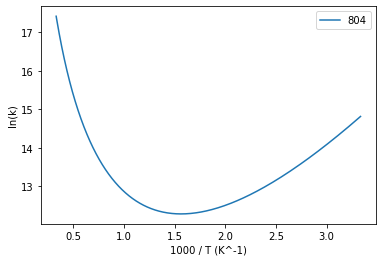

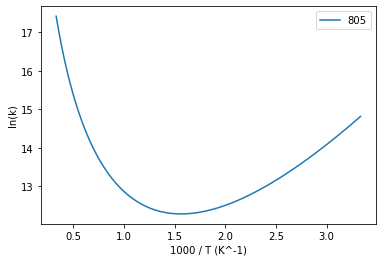

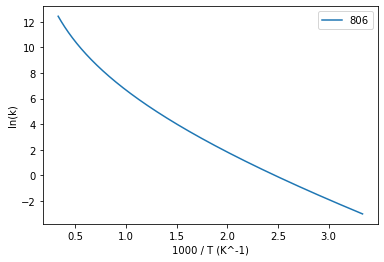

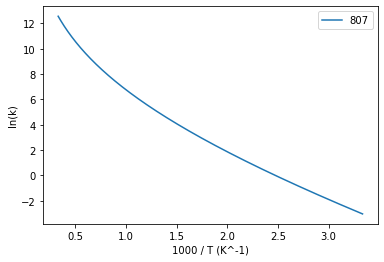

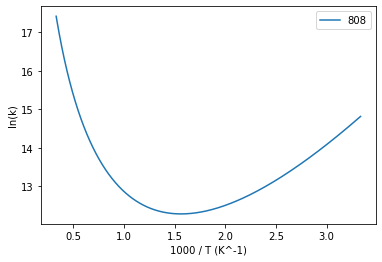

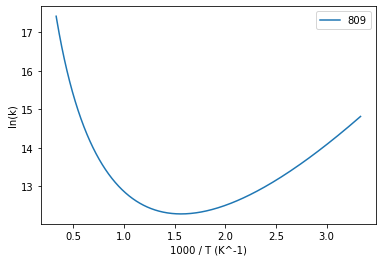

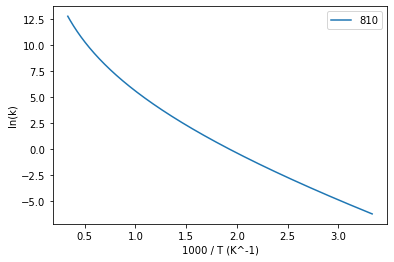

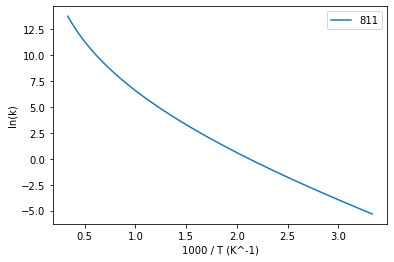

In [29]:
for i in range(804, 812):
    plot_kinetics(reaction_list[i], [str(i)])

In [ ]:
def get_rmg_reaction(ct_index):
    ct_reaction = base_gas.reactions()[ct_index]
    new_rmg_rxn = rmgpy.reaction.Reaction()
    new_rmg_rxn.reactants = []
    new_rmg_rxn.products = []
    for reactant in ct_reaction.reactants.keys():
        new_rmg_rxn.reactants.append(spec_dict[reactant])
    for product in ct_reaction.products.keys():
        new_rmg_rxn.products.append(spec_dict[product])
    return new_rmg_rxn

In [ ]:
for ct_index in range(832, 840):

    ref_rmg_rxn = get_rmg_reaction(ct_index)
    for i, rxn in enumerate(reaction_list):
        if rxn.is_isomorphic(ref_rmg_rxn):
            print(ct_index, i)
            break

In [ ]:
print(gas85.forward_rates_of_progress[832])
print(gas85.reverse_rates_of_progress[832])
print(gas85.net_rates_of_progress[832])
print(gas85.forward_rates_of_progress[832]-gas85.reverse_rates_of_progress[832])

In [22]:
len(base_gas.forward_rates_of_progress)

1850

In [ ]:
len(base_gas.reactions())

In [ ]:
print(len(relevant_reactions))

In [20]:
dir(gas85)

['DP',
 'DPX',
 'DPY',
 'HP',
 'HPX',
 'HPY',
 'ID',
 'P',
 'P_sat',
 'SP',
 'SPX',
 'SPY',
 'SV',
 'SVX',
 'SVY',
 'T',
 'TD',
 'TDX',
 'TDY',
 'TP',
 'TPX',
 'TPY',
 'T_sat',
 'UV',
 'UVX',
 'UVY',
 'X',
 'Y',
 '__call__',
 '__class__',
 '__composition_to_array',
 '__copy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_check_kinetics_species_index',
 '_check_phase_index',
 '_check_reaction_index',
 '_full_states',
 '_init_cti_xml',
 '_init_parts',
 '_init_yaml',
 '_native_state',
 '_partial_states',
 '_references',
 'activities',
 'activity_coefficients',
 'add_reaction',
 'add_species',
 'add_species_alias',
 'atomic_weight',
 'atomic_weights',
 'basis',

In [ ]:
reactor85.thermo.X[85]

In [ ]:
gas85.species()[85]

In [ ]:
gas.species()[85]

In [ ]:
T

In [ ]:
species_list[85].is_isomorphic(spec_dict['S(787)'])

In [ ]:
spec_dict['S(787)']

In [ ]:
species_list[85]